In [357]:
import Tom_Model as TM
import pandas as pd
import numpy as np
import random

from collections import defaultdict
from copy import deepcopy

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import matplotlib.pyplot as plt
from pandas.plotting import table
import matplotlib.colors as cl

from tabulate import tabulate

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [358]:
theta = 1.7

In [359]:
iterations = 10000

In [360]:
init_table_file = 'CAF_initial.csv'
current_table_file = 'CAF_current.csv'

init_sched_file = 'CAF_schedule_init.csv'
current_sched_file = 'CAF_schedule_current.csv'

In [361]:
current = input('Do you want to use current Elo, Points, and Schedule? \n Y - Start from Current Spot. \n N - Start from the Beginning. \n')

if current == 'Y':
    quals_group_table = pd.read_csv(current_table_file, header=0)
    matches = pd.read_csv(current_sched_file, header=0)
    
elif current == 'N':
    quals_group_table = pd.read_csv(init_table_file, header=0)
    matches = pd.read_csv(init_sched_file, header=0)
    
else:
    print('Please Pick a Valid Response.')

Do you want to use current Elo, Points, and Schedule? 
 Y - Start from Current Spot. 
 N - Start from the Beginning. 
Y


In [362]:
quals_group_table = quals_group_table.set_index('Code')

init_group_table = deepcopy(quals_group_table)

In [363]:
team_tuples = [(x, y) for x, y in zip(quals_group_table['Group'][:54], quals_group_table.index[:54])]

cols = pd.MultiIndex.from_tuples(team_tuples)

#Create dataframe with MultiIndex columns
placement_table = pd.DataFrame(0,
                            index = np.arange(1, 7),
                            columns = cols)

#finish table
finish_table = pd.DataFrame(0,
                            index = quals_group_table.index[:54],
                            columns = ['Interconfed Playoff', 'Qualify'])

#second place table
second_table = pd.DataFrame(0,
                            index = np.arange(1, 10),
                            columns = ['Team', 'Points'])

init_second_table = deepcopy(second_table)

In [364]:
groups = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

total_table = quals_group_table.loc[:, ['Points', 'Group']].copy()
total_table['R2 SF'] = 0
total_table['R2 F'] = 0

In [365]:
num_matches = len(matches['Match Num'])

In [366]:
for iteration in range(iterations):
    
    r1_table = quals_group_table.iloc[:len(quals_group_table)-4, :]
    r2_table = quals_group_table[quals_group_table['Group'] == "R2"]
    
    r1_matches = matches[:num_matches-3]
    r2_SF = matches[matches['Group'] == "R2 SF"]
    r2_F = matches[matches['Group'] == "R2 F"]
    
    for match in range(len(r1_matches.index)-1):
        
        #calculate win expectancies
        home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_match_We(matches, 
                                                                       match, quals_group_table)
        
        #Determine win probability for each team
        home_wp = TM.davidson_home_wp(home_we, away_we, theta)
        away_wp = TM.davidson_away_wp(home_we, away_we, theta)
        draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)

        quals_group_table = TM.play_gs_match_neutral(quals_group_table, home_team, home_we, home_elo, home_wp, 
                          away_team, away_we, away_elo, away_wp, draw_wp)
        
    for team in r1_table.index:
        team_points = r1_table.loc[team, 'Points']
        total_table.loc[team, 'Points'] += team_points
        
    for ind, group in enumerate(groups):
        
        group_tab = r1_table[r1_table['Group'] == group]
        ranked_group_tab = group_tab.sort_values(by='Points', ascending=False)
        ranked_group_tab['Rank'] = group_tab['Points'].rank(method='max', ascending = False)

        for team in ranked_group_tab.index:
            rank = ranked_group_tab.loc[team, 'Rank']
            group = ranked_group_tab.loc[team, 'Group']

            placement_table.loc[rank, (group, team)] += 1
            
        second_place = ranked_group_tab.index[1]
            
        second_table.loc[ind, 'Team'] = second_place
        second_table.loc[ind, 'Points'] = ranked_group_tab.loc[second_place, 'Points']
        
    second_table_ranked = second_table.sort_values(by='Points', ascending=False)
    
    r2_table = r2_table.set_index(second_table_ranked['Team'][0:4])
    
    for team in r2_table.index:
        r2_table.loc[team, ['Points', 'Elo']] = r1_table.loc[team, ['Points', 'Elo']]
        total_table.loc[team, 'R2 SF'] += 1
    
    r2_SF.loc[num_matches-3, 'Home'] = r2_table.index[0]
    r2_SF.loc[num_matches-3, 'Away'] = r2_table.index[3]
    
    r2_SF.loc[num_matches-2, 'Home'] = r2_table.index[1]
    r2_SF.loc[num_matches-2, 'Away'] = r2_table.index[2]
    
    
    for match in range(num_matches-3, num_matches-1):
            
        #calculate win expectancies
        home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_match_We(r2_SF, match, r2_table)
        
        #Determine win probability for each team
        home_wp = TM.davidson_home_wp(home_we, away_we, theta)
        away_wp = TM.davidson_away_wp(home_we, away_we, theta)
        draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)

        r2_table, r2_SF = TM.play_ko_match(r2_table, r2_SF, match, home_team, home_we, 
                                                       home_elo, home_wp, away_team, 
                                                       away_we, away_elo, away_wp, 
                                                       draw_wp)
        
    R2_winners = list(r2_SF['Winner'])
    
    winners_points = []
    
    #higher ranked country hosts final
    for winner in R2_winners:
        winners_points.append(r2_table.loc[winner, 'Points'])
    
    if winners_points[0] == winners_points[1]:
        
        h_a = random.sample([0,1], 2)
        
        home = h_a[0]
        away = h_a[1]
    
    else:
        
        home = winners_points.index(max(winners_points))
        away = winners_points.index(min(winners_points))
    
    r2_F.loc[num_matches-1, 'Home'] = R2_winners[home]
    r2_F.loc[num_matches-1, 'Away'] = R2_winners[away]
    
    home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_match_We(r2_F, num_matches-1, r2_table)

    #Determine win probability for each team
    home_wp = TM.davidson_home_wp(home_we, away_we, theta)
    away_wp = TM.davidson_away_wp(home_we, away_we, theta)
    draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)

    r2_table, r2_F = TM.play_ko_match(r2_table, r2_F, num_matches-1, home_team, home_we, 
                                      home_elo, home_wp, away_team, 
                                      away_we, away_elo, away_wp, draw_wp)
    
    for team in finish_table.index:
        if team in list(r2_SF['Winner']):
            total_table.loc[team, 'R2 F'] += 1
        else:
            continue
            
    r2_winner = r2_F.loc[num_matches-1,'Winner']
    
    finish_table.loc[r2_winner, 'Interconfed Playoff'] += 1
            
    quals_group_table = deepcopy(init_group_table)
    
    print(f'Iteration {iteration} / {iterations}')

/Users/thomasgaudin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Iteration 0 / 10000
Iteration 1 / 10000
Iteration 2 / 10000
Iteration 3 / 10000
Iteration 4 / 10000
Iteration 5 / 10000
Iteration 6 / 10000
Iteration 7 / 10000
Iteration 8 / 10000
Iteration 9 / 10000
Iteration 10 / 10000
Iteration 11 / 10000
Iteration 12 / 10000
Iteration 13 / 10000
Iteration 14 / 10000
Iteration 15 / 10000
Iteration 16 / 10000
Iteration 17 / 10000
Iteration 18 / 10000
Iteration 19 / 10000
Iteration 20 / 10000
Iteration 21 / 10000
Iteration 22 / 10000
Iteration 23 / 10000
Iteration 24 / 10000
Iteration 25 / 10000
Iteration 26 / 10000
Iteration 27 / 10000
Iteration 28 / 10000
Iteration 29 / 10000
Iteration 30 / 10000
Iteration 31 / 10000
Iteration 32 / 10000
Iteration 33 / 10000
Iteration 34 / 10000
Iteration 35 / 10000
Iteration 36 / 10000
Iteration 37 / 10000
Iteration 38 / 10000
Iteration 39 / 10000
Iteration 40 / 10000
Iteration 41 / 10000
Iteration 42 / 10000
Iteration 43 / 10000
Iteration 44 / 10000
Iteration 45 / 10000
Iteration 46 / 10000
Iteration 47 / 10000
It

Iteration 378 / 10000
Iteration 379 / 10000
Iteration 380 / 10000
Iteration 381 / 10000
Iteration 382 / 10000
Iteration 383 / 10000
Iteration 384 / 10000
Iteration 385 / 10000
Iteration 386 / 10000
Iteration 387 / 10000
Iteration 388 / 10000
Iteration 389 / 10000
Iteration 390 / 10000
Iteration 391 / 10000
Iteration 392 / 10000
Iteration 393 / 10000
Iteration 394 / 10000
Iteration 395 / 10000
Iteration 396 / 10000
Iteration 397 / 10000
Iteration 398 / 10000
Iteration 399 / 10000
Iteration 400 / 10000
Iteration 401 / 10000
Iteration 402 / 10000
Iteration 403 / 10000
Iteration 404 / 10000
Iteration 405 / 10000
Iteration 406 / 10000
Iteration 407 / 10000
Iteration 408 / 10000
Iteration 409 / 10000
Iteration 410 / 10000
Iteration 411 / 10000
Iteration 412 / 10000
Iteration 413 / 10000
Iteration 414 / 10000
Iteration 415 / 10000
Iteration 416 / 10000
Iteration 417 / 10000
Iteration 418 / 10000
Iteration 419 / 10000
Iteration 420 / 10000
Iteration 421 / 10000
Iteration 422 / 10000
Iteration 

Iteration 752 / 10000
Iteration 753 / 10000
Iteration 754 / 10000
Iteration 755 / 10000
Iteration 756 / 10000
Iteration 757 / 10000
Iteration 758 / 10000
Iteration 759 / 10000
Iteration 760 / 10000
Iteration 761 / 10000
Iteration 762 / 10000
Iteration 763 / 10000
Iteration 764 / 10000
Iteration 765 / 10000
Iteration 766 / 10000
Iteration 767 / 10000
Iteration 768 / 10000
Iteration 769 / 10000
Iteration 770 / 10000
Iteration 771 / 10000
Iteration 772 / 10000
Iteration 773 / 10000
Iteration 774 / 10000
Iteration 775 / 10000
Iteration 776 / 10000
Iteration 777 / 10000
Iteration 778 / 10000
Iteration 779 / 10000
Iteration 780 / 10000
Iteration 781 / 10000
Iteration 782 / 10000
Iteration 783 / 10000
Iteration 784 / 10000
Iteration 785 / 10000
Iteration 786 / 10000
Iteration 787 / 10000
Iteration 788 / 10000
Iteration 789 / 10000
Iteration 790 / 10000
Iteration 791 / 10000
Iteration 792 / 10000
Iteration 793 / 10000
Iteration 794 / 10000
Iteration 795 / 10000
Iteration 796 / 10000
Iteration 

Iteration 1120 / 10000
Iteration 1121 / 10000
Iteration 1122 / 10000
Iteration 1123 / 10000
Iteration 1124 / 10000
Iteration 1125 / 10000
Iteration 1126 / 10000
Iteration 1127 / 10000
Iteration 1128 / 10000
Iteration 1129 / 10000
Iteration 1130 / 10000
Iteration 1131 / 10000
Iteration 1132 / 10000
Iteration 1133 / 10000
Iteration 1134 / 10000
Iteration 1135 / 10000
Iteration 1136 / 10000
Iteration 1137 / 10000
Iteration 1138 / 10000
Iteration 1139 / 10000
Iteration 1140 / 10000
Iteration 1141 / 10000
Iteration 1142 / 10000
Iteration 1143 / 10000
Iteration 1144 / 10000
Iteration 1145 / 10000
Iteration 1146 / 10000
Iteration 1147 / 10000
Iteration 1148 / 10000
Iteration 1149 / 10000
Iteration 1150 / 10000
Iteration 1151 / 10000
Iteration 1152 / 10000
Iteration 1153 / 10000
Iteration 1154 / 10000
Iteration 1155 / 10000
Iteration 1156 / 10000
Iteration 1157 / 10000
Iteration 1158 / 10000
Iteration 1159 / 10000
Iteration 1160 / 10000
Iteration 1161 / 10000
Iteration 1162 / 10000
Iteration 1

Iteration 1478 / 10000
Iteration 1479 / 10000
Iteration 1480 / 10000
Iteration 1481 / 10000
Iteration 1482 / 10000
Iteration 1483 / 10000
Iteration 1484 / 10000
Iteration 1485 / 10000
Iteration 1486 / 10000
Iteration 1487 / 10000
Iteration 1488 / 10000
Iteration 1489 / 10000
Iteration 1490 / 10000
Iteration 1491 / 10000
Iteration 1492 / 10000
Iteration 1493 / 10000
Iteration 1494 / 10000
Iteration 1495 / 10000
Iteration 1496 / 10000
Iteration 1497 / 10000
Iteration 1498 / 10000
Iteration 1499 / 10000
Iteration 1500 / 10000
Iteration 1501 / 10000
Iteration 1502 / 10000
Iteration 1503 / 10000
Iteration 1504 / 10000
Iteration 1505 / 10000
Iteration 1506 / 10000
Iteration 1507 / 10000
Iteration 1508 / 10000
Iteration 1509 / 10000
Iteration 1510 / 10000
Iteration 1511 / 10000
Iteration 1512 / 10000
Iteration 1513 / 10000
Iteration 1514 / 10000
Iteration 1515 / 10000
Iteration 1516 / 10000
Iteration 1517 / 10000
Iteration 1518 / 10000
Iteration 1519 / 10000
Iteration 1520 / 10000
Iteration 1

Iteration 1836 / 10000
Iteration 1837 / 10000
Iteration 1838 / 10000
Iteration 1839 / 10000
Iteration 1840 / 10000
Iteration 1841 / 10000
Iteration 1842 / 10000
Iteration 1843 / 10000
Iteration 1844 / 10000
Iteration 1845 / 10000
Iteration 1846 / 10000
Iteration 1847 / 10000
Iteration 1848 / 10000
Iteration 1849 / 10000
Iteration 1850 / 10000
Iteration 1851 / 10000
Iteration 1852 / 10000
Iteration 1853 / 10000
Iteration 1854 / 10000
Iteration 1855 / 10000
Iteration 1856 / 10000
Iteration 1857 / 10000
Iteration 1858 / 10000
Iteration 1859 / 10000
Iteration 1860 / 10000
Iteration 1861 / 10000
Iteration 1862 / 10000
Iteration 1863 / 10000
Iteration 1864 / 10000
Iteration 1865 / 10000
Iteration 1866 / 10000
Iteration 1867 / 10000
Iteration 1868 / 10000
Iteration 1869 / 10000
Iteration 1870 / 10000
Iteration 1871 / 10000
Iteration 1872 / 10000
Iteration 1873 / 10000
Iteration 1874 / 10000
Iteration 1875 / 10000
Iteration 1876 / 10000
Iteration 1877 / 10000
Iteration 1878 / 10000
Iteration 1

Iteration 2195 / 10000
Iteration 2196 / 10000
Iteration 2197 / 10000
Iteration 2198 / 10000
Iteration 2199 / 10000
Iteration 2200 / 10000
Iteration 2201 / 10000
Iteration 2202 / 10000
Iteration 2203 / 10000
Iteration 2204 / 10000
Iteration 2205 / 10000
Iteration 2206 / 10000
Iteration 2207 / 10000
Iteration 2208 / 10000
Iteration 2209 / 10000
Iteration 2210 / 10000
Iteration 2211 / 10000
Iteration 2212 / 10000
Iteration 2213 / 10000
Iteration 2214 / 10000
Iteration 2215 / 10000
Iteration 2216 / 10000
Iteration 2217 / 10000
Iteration 2218 / 10000
Iteration 2219 / 10000
Iteration 2220 / 10000
Iteration 2221 / 10000
Iteration 2222 / 10000
Iteration 2223 / 10000
Iteration 2224 / 10000
Iteration 2225 / 10000
Iteration 2226 / 10000
Iteration 2227 / 10000
Iteration 2228 / 10000
Iteration 2229 / 10000
Iteration 2230 / 10000
Iteration 2231 / 10000
Iteration 2232 / 10000
Iteration 2233 / 10000
Iteration 2234 / 10000
Iteration 2235 / 10000
Iteration 2236 / 10000
Iteration 2237 / 10000
Iteration 2

Iteration 2552 / 10000
Iteration 2553 / 10000
Iteration 2554 / 10000
Iteration 2555 / 10000
Iteration 2556 / 10000
Iteration 2557 / 10000
Iteration 2558 / 10000
Iteration 2559 / 10000
Iteration 2560 / 10000
Iteration 2561 / 10000
Iteration 2562 / 10000
Iteration 2563 / 10000
Iteration 2564 / 10000
Iteration 2565 / 10000
Iteration 2566 / 10000
Iteration 2567 / 10000
Iteration 2568 / 10000
Iteration 2569 / 10000
Iteration 2570 / 10000
Iteration 2571 / 10000
Iteration 2572 / 10000
Iteration 2573 / 10000
Iteration 2574 / 10000
Iteration 2575 / 10000
Iteration 2576 / 10000
Iteration 2577 / 10000
Iteration 2578 / 10000
Iteration 2579 / 10000
Iteration 2580 / 10000
Iteration 2581 / 10000
Iteration 2582 / 10000
Iteration 2583 / 10000
Iteration 2584 / 10000
Iteration 2585 / 10000
Iteration 2586 / 10000
Iteration 2587 / 10000
Iteration 2588 / 10000
Iteration 2589 / 10000
Iteration 2590 / 10000
Iteration 2591 / 10000
Iteration 2592 / 10000
Iteration 2593 / 10000
Iteration 2594 / 10000
Iteration 2

Iteration 2910 / 10000
Iteration 2911 / 10000
Iteration 2912 / 10000
Iteration 2913 / 10000
Iteration 2914 / 10000
Iteration 2915 / 10000
Iteration 2916 / 10000
Iteration 2917 / 10000
Iteration 2918 / 10000
Iteration 2919 / 10000
Iteration 2920 / 10000
Iteration 2921 / 10000
Iteration 2922 / 10000
Iteration 2923 / 10000
Iteration 2924 / 10000
Iteration 2925 / 10000
Iteration 2926 / 10000
Iteration 2927 / 10000
Iteration 2928 / 10000
Iteration 2929 / 10000
Iteration 2930 / 10000
Iteration 2931 / 10000
Iteration 2932 / 10000
Iteration 2933 / 10000
Iteration 2934 / 10000
Iteration 2935 / 10000
Iteration 2936 / 10000
Iteration 2937 / 10000
Iteration 2938 / 10000
Iteration 2939 / 10000
Iteration 2940 / 10000
Iteration 2941 / 10000
Iteration 2942 / 10000
Iteration 2943 / 10000
Iteration 2944 / 10000
Iteration 2945 / 10000
Iteration 2946 / 10000
Iteration 2947 / 10000
Iteration 2948 / 10000
Iteration 2949 / 10000
Iteration 2950 / 10000
Iteration 2951 / 10000
Iteration 2952 / 10000
Iteration 2

Iteration 3268 / 10000
Iteration 3269 / 10000
Iteration 3270 / 10000
Iteration 3271 / 10000
Iteration 3272 / 10000
Iteration 3273 / 10000
Iteration 3274 / 10000
Iteration 3275 / 10000
Iteration 3276 / 10000
Iteration 3277 / 10000
Iteration 3278 / 10000
Iteration 3279 / 10000
Iteration 3280 / 10000
Iteration 3281 / 10000
Iteration 3282 / 10000
Iteration 3283 / 10000
Iteration 3284 / 10000
Iteration 3285 / 10000
Iteration 3286 / 10000
Iteration 3287 / 10000
Iteration 3288 / 10000
Iteration 3289 / 10000
Iteration 3290 / 10000
Iteration 3291 / 10000
Iteration 3292 / 10000
Iteration 3293 / 10000
Iteration 3294 / 10000
Iteration 3295 / 10000
Iteration 3296 / 10000
Iteration 3297 / 10000
Iteration 3298 / 10000
Iteration 3299 / 10000
Iteration 3300 / 10000
Iteration 3301 / 10000
Iteration 3302 / 10000
Iteration 3303 / 10000
Iteration 3304 / 10000
Iteration 3305 / 10000
Iteration 3306 / 10000
Iteration 3307 / 10000
Iteration 3308 / 10000
Iteration 3309 / 10000
Iteration 3310 / 10000
Iteration 3

Iteration 3626 / 10000
Iteration 3627 / 10000
Iteration 3628 / 10000
Iteration 3629 / 10000
Iteration 3630 / 10000
Iteration 3631 / 10000
Iteration 3632 / 10000
Iteration 3633 / 10000
Iteration 3634 / 10000
Iteration 3635 / 10000
Iteration 3636 / 10000
Iteration 3637 / 10000
Iteration 3638 / 10000
Iteration 3639 / 10000
Iteration 3640 / 10000
Iteration 3641 / 10000
Iteration 3642 / 10000
Iteration 3643 / 10000
Iteration 3644 / 10000
Iteration 3645 / 10000
Iteration 3646 / 10000
Iteration 3647 / 10000
Iteration 3648 / 10000
Iteration 3649 / 10000
Iteration 3650 / 10000
Iteration 3651 / 10000
Iteration 3652 / 10000
Iteration 3653 / 10000
Iteration 3654 / 10000
Iteration 3655 / 10000
Iteration 3656 / 10000
Iteration 3657 / 10000
Iteration 3658 / 10000
Iteration 3659 / 10000
Iteration 3660 / 10000
Iteration 3661 / 10000
Iteration 3662 / 10000
Iteration 3663 / 10000
Iteration 3664 / 10000
Iteration 3665 / 10000
Iteration 3666 / 10000
Iteration 3667 / 10000
Iteration 3668 / 10000
Iteration 3

Iteration 3984 / 10000
Iteration 3985 / 10000
Iteration 3986 / 10000
Iteration 3987 / 10000
Iteration 3988 / 10000
Iteration 3989 / 10000
Iteration 3990 / 10000
Iteration 3991 / 10000
Iteration 3992 / 10000
Iteration 3993 / 10000
Iteration 3994 / 10000
Iteration 3995 / 10000
Iteration 3996 / 10000
Iteration 3997 / 10000
Iteration 3998 / 10000
Iteration 3999 / 10000
Iteration 4000 / 10000
Iteration 4001 / 10000
Iteration 4002 / 10000
Iteration 4003 / 10000
Iteration 4004 / 10000
Iteration 4005 / 10000
Iteration 4006 / 10000
Iteration 4007 / 10000
Iteration 4008 / 10000
Iteration 4009 / 10000
Iteration 4010 / 10000
Iteration 4011 / 10000
Iteration 4012 / 10000
Iteration 4013 / 10000
Iteration 4014 / 10000
Iteration 4015 / 10000
Iteration 4016 / 10000
Iteration 4017 / 10000
Iteration 4018 / 10000
Iteration 4019 / 10000
Iteration 4020 / 10000
Iteration 4021 / 10000
Iteration 4022 / 10000
Iteration 4023 / 10000
Iteration 4024 / 10000
Iteration 4025 / 10000
Iteration 4026 / 10000
Iteration 4

Iteration 4340 / 10000
Iteration 4341 / 10000
Iteration 4342 / 10000
Iteration 4343 / 10000
Iteration 4344 / 10000
Iteration 4345 / 10000
Iteration 4346 / 10000
Iteration 4347 / 10000
Iteration 4348 / 10000
Iteration 4349 / 10000
Iteration 4350 / 10000
Iteration 4351 / 10000
Iteration 4352 / 10000
Iteration 4353 / 10000
Iteration 4354 / 10000
Iteration 4355 / 10000
Iteration 4356 / 10000
Iteration 4357 / 10000
Iteration 4358 / 10000
Iteration 4359 / 10000
Iteration 4360 / 10000
Iteration 4361 / 10000
Iteration 4362 / 10000
Iteration 4363 / 10000
Iteration 4364 / 10000
Iteration 4365 / 10000
Iteration 4366 / 10000
Iteration 4367 / 10000
Iteration 4368 / 10000
Iteration 4369 / 10000
Iteration 4370 / 10000
Iteration 4371 / 10000
Iteration 4372 / 10000
Iteration 4373 / 10000
Iteration 4374 / 10000
Iteration 4375 / 10000
Iteration 4376 / 10000
Iteration 4377 / 10000
Iteration 4378 / 10000
Iteration 4379 / 10000
Iteration 4380 / 10000
Iteration 4381 / 10000
Iteration 4382 / 10000
Iteration 4

Iteration 4698 / 10000
Iteration 4699 / 10000
Iteration 4700 / 10000
Iteration 4701 / 10000
Iteration 4702 / 10000
Iteration 4703 / 10000
Iteration 4704 / 10000
Iteration 4705 / 10000
Iteration 4706 / 10000
Iteration 4707 / 10000
Iteration 4708 / 10000
Iteration 4709 / 10000
Iteration 4710 / 10000
Iteration 4711 / 10000
Iteration 4712 / 10000
Iteration 4713 / 10000
Iteration 4714 / 10000
Iteration 4715 / 10000
Iteration 4716 / 10000
Iteration 4717 / 10000
Iteration 4718 / 10000
Iteration 4719 / 10000
Iteration 4720 / 10000
Iteration 4721 / 10000
Iteration 4722 / 10000
Iteration 4723 / 10000
Iteration 4724 / 10000
Iteration 4725 / 10000
Iteration 4726 / 10000
Iteration 4727 / 10000
Iteration 4728 / 10000
Iteration 4729 / 10000
Iteration 4730 / 10000
Iteration 4731 / 10000
Iteration 4732 / 10000
Iteration 4733 / 10000
Iteration 4734 / 10000
Iteration 4735 / 10000
Iteration 4736 / 10000
Iteration 4737 / 10000
Iteration 4738 / 10000
Iteration 4739 / 10000
Iteration 4740 / 10000
Iteration 4

Iteration 5055 / 10000
Iteration 5056 / 10000
Iteration 5057 / 10000
Iteration 5058 / 10000
Iteration 5059 / 10000
Iteration 5060 / 10000
Iteration 5061 / 10000
Iteration 5062 / 10000
Iteration 5063 / 10000
Iteration 5064 / 10000
Iteration 5065 / 10000
Iteration 5066 / 10000
Iteration 5067 / 10000
Iteration 5068 / 10000
Iteration 5069 / 10000
Iteration 5070 / 10000
Iteration 5071 / 10000
Iteration 5072 / 10000
Iteration 5073 / 10000
Iteration 5074 / 10000
Iteration 5075 / 10000
Iteration 5076 / 10000
Iteration 5077 / 10000
Iteration 5078 / 10000
Iteration 5079 / 10000
Iteration 5080 / 10000
Iteration 5081 / 10000
Iteration 5082 / 10000
Iteration 5083 / 10000
Iteration 5084 / 10000
Iteration 5085 / 10000
Iteration 5086 / 10000
Iteration 5087 / 10000
Iteration 5088 / 10000
Iteration 5089 / 10000
Iteration 5090 / 10000
Iteration 5091 / 10000
Iteration 5092 / 10000
Iteration 5093 / 10000
Iteration 5094 / 10000
Iteration 5095 / 10000
Iteration 5096 / 10000
Iteration 5097 / 10000
Iteration 5

Iteration 5413 / 10000
Iteration 5414 / 10000
Iteration 5415 / 10000
Iteration 5416 / 10000
Iteration 5417 / 10000
Iteration 5418 / 10000
Iteration 5419 / 10000
Iteration 5420 / 10000
Iteration 5421 / 10000
Iteration 5422 / 10000
Iteration 5423 / 10000
Iteration 5424 / 10000
Iteration 5425 / 10000
Iteration 5426 / 10000
Iteration 5427 / 10000
Iteration 5428 / 10000
Iteration 5429 / 10000
Iteration 5430 / 10000
Iteration 5431 / 10000
Iteration 5432 / 10000
Iteration 5433 / 10000
Iteration 5434 / 10000
Iteration 5435 / 10000
Iteration 5436 / 10000
Iteration 5437 / 10000
Iteration 5438 / 10000
Iteration 5439 / 10000
Iteration 5440 / 10000
Iteration 5441 / 10000
Iteration 5442 / 10000
Iteration 5443 / 10000
Iteration 5444 / 10000
Iteration 5445 / 10000
Iteration 5446 / 10000
Iteration 5447 / 10000
Iteration 5448 / 10000
Iteration 5449 / 10000
Iteration 5450 / 10000
Iteration 5451 / 10000
Iteration 5452 / 10000
Iteration 5453 / 10000
Iteration 5454 / 10000
Iteration 5455 / 10000
Iteration 5

Iteration 5770 / 10000
Iteration 5771 / 10000
Iteration 5772 / 10000
Iteration 5773 / 10000
Iteration 5774 / 10000
Iteration 5775 / 10000
Iteration 5776 / 10000
Iteration 5777 / 10000
Iteration 5778 / 10000
Iteration 5779 / 10000
Iteration 5780 / 10000
Iteration 5781 / 10000
Iteration 5782 / 10000
Iteration 5783 / 10000
Iteration 5784 / 10000
Iteration 5785 / 10000
Iteration 5786 / 10000
Iteration 5787 / 10000
Iteration 5788 / 10000
Iteration 5789 / 10000
Iteration 5790 / 10000
Iteration 5791 / 10000
Iteration 5792 / 10000
Iteration 5793 / 10000
Iteration 5794 / 10000
Iteration 5795 / 10000
Iteration 5796 / 10000
Iteration 5797 / 10000
Iteration 5798 / 10000
Iteration 5799 / 10000
Iteration 5800 / 10000
Iteration 5801 / 10000
Iteration 5802 / 10000
Iteration 5803 / 10000
Iteration 5804 / 10000
Iteration 5805 / 10000
Iteration 5806 / 10000
Iteration 5807 / 10000
Iteration 5808 / 10000
Iteration 5809 / 10000
Iteration 5810 / 10000
Iteration 5811 / 10000
Iteration 5812 / 10000
Iteration 5

Iteration 6130 / 10000
Iteration 6131 / 10000
Iteration 6132 / 10000
Iteration 6133 / 10000
Iteration 6134 / 10000
Iteration 6135 / 10000
Iteration 6136 / 10000
Iteration 6137 / 10000
Iteration 6138 / 10000
Iteration 6139 / 10000
Iteration 6140 / 10000
Iteration 6141 / 10000
Iteration 6142 / 10000
Iteration 6143 / 10000
Iteration 6144 / 10000
Iteration 6145 / 10000
Iteration 6146 / 10000
Iteration 6147 / 10000
Iteration 6148 / 10000
Iteration 6149 / 10000
Iteration 6150 / 10000
Iteration 6151 / 10000
Iteration 6152 / 10000
Iteration 6153 / 10000
Iteration 6154 / 10000
Iteration 6155 / 10000
Iteration 6156 / 10000
Iteration 6157 / 10000
Iteration 6158 / 10000
Iteration 6159 / 10000
Iteration 6160 / 10000
Iteration 6161 / 10000
Iteration 6162 / 10000
Iteration 6163 / 10000
Iteration 6164 / 10000
Iteration 6165 / 10000
Iteration 6166 / 10000
Iteration 6167 / 10000
Iteration 6168 / 10000
Iteration 6169 / 10000
Iteration 6170 / 10000
Iteration 6171 / 10000
Iteration 6172 / 10000
Iteration 6

Iteration 6487 / 10000
Iteration 6488 / 10000
Iteration 6489 / 10000
Iteration 6490 / 10000
Iteration 6491 / 10000
Iteration 6492 / 10000
Iteration 6493 / 10000
Iteration 6494 / 10000
Iteration 6495 / 10000
Iteration 6496 / 10000
Iteration 6497 / 10000
Iteration 6498 / 10000
Iteration 6499 / 10000
Iteration 6500 / 10000
Iteration 6501 / 10000
Iteration 6502 / 10000
Iteration 6503 / 10000
Iteration 6504 / 10000
Iteration 6505 / 10000
Iteration 6506 / 10000
Iteration 6507 / 10000
Iteration 6508 / 10000
Iteration 6509 / 10000
Iteration 6510 / 10000
Iteration 6511 / 10000
Iteration 6512 / 10000
Iteration 6513 / 10000
Iteration 6514 / 10000
Iteration 6515 / 10000
Iteration 6516 / 10000
Iteration 6517 / 10000
Iteration 6518 / 10000
Iteration 6519 / 10000
Iteration 6520 / 10000
Iteration 6521 / 10000
Iteration 6522 / 10000
Iteration 6523 / 10000
Iteration 6524 / 10000
Iteration 6525 / 10000
Iteration 6526 / 10000
Iteration 6527 / 10000
Iteration 6528 / 10000
Iteration 6529 / 10000
Iteration 6

Iteration 6846 / 10000
Iteration 6847 / 10000
Iteration 6848 / 10000
Iteration 6849 / 10000
Iteration 6850 / 10000
Iteration 6851 / 10000
Iteration 6852 / 10000
Iteration 6853 / 10000
Iteration 6854 / 10000
Iteration 6855 / 10000
Iteration 6856 / 10000
Iteration 6857 / 10000
Iteration 6858 / 10000
Iteration 6859 / 10000
Iteration 6860 / 10000
Iteration 6861 / 10000
Iteration 6862 / 10000
Iteration 6863 / 10000
Iteration 6864 / 10000
Iteration 6865 / 10000
Iteration 6866 / 10000
Iteration 6867 / 10000
Iteration 6868 / 10000
Iteration 6869 / 10000
Iteration 6870 / 10000
Iteration 6871 / 10000
Iteration 6872 / 10000
Iteration 6873 / 10000
Iteration 6874 / 10000
Iteration 6875 / 10000
Iteration 6876 / 10000
Iteration 6877 / 10000
Iteration 6878 / 10000
Iteration 6879 / 10000
Iteration 6880 / 10000
Iteration 6881 / 10000
Iteration 6882 / 10000
Iteration 6883 / 10000
Iteration 6884 / 10000
Iteration 6885 / 10000
Iteration 6886 / 10000
Iteration 6887 / 10000
Iteration 6888 / 10000
Iteration 6

Iteration 7203 / 10000
Iteration 7204 / 10000
Iteration 7205 / 10000
Iteration 7206 / 10000
Iteration 7207 / 10000
Iteration 7208 / 10000
Iteration 7209 / 10000
Iteration 7210 / 10000
Iteration 7211 / 10000
Iteration 7212 / 10000
Iteration 7213 / 10000
Iteration 7214 / 10000
Iteration 7215 / 10000
Iteration 7216 / 10000
Iteration 7217 / 10000
Iteration 7218 / 10000
Iteration 7219 / 10000
Iteration 7220 / 10000
Iteration 7221 / 10000
Iteration 7222 / 10000
Iteration 7223 / 10000
Iteration 7224 / 10000
Iteration 7225 / 10000
Iteration 7226 / 10000
Iteration 7227 / 10000
Iteration 7228 / 10000
Iteration 7229 / 10000
Iteration 7230 / 10000
Iteration 7231 / 10000
Iteration 7232 / 10000
Iteration 7233 / 10000
Iteration 7234 / 10000
Iteration 7235 / 10000
Iteration 7236 / 10000
Iteration 7237 / 10000
Iteration 7238 / 10000
Iteration 7239 / 10000
Iteration 7240 / 10000
Iteration 7241 / 10000
Iteration 7242 / 10000
Iteration 7243 / 10000
Iteration 7244 / 10000
Iteration 7245 / 10000
Iteration 7

Iteration 7562 / 10000
Iteration 7563 / 10000
Iteration 7564 / 10000
Iteration 7565 / 10000
Iteration 7566 / 10000
Iteration 7567 / 10000
Iteration 7568 / 10000
Iteration 7569 / 10000
Iteration 7570 / 10000
Iteration 7571 / 10000
Iteration 7572 / 10000
Iteration 7573 / 10000
Iteration 7574 / 10000
Iteration 7575 / 10000
Iteration 7576 / 10000
Iteration 7577 / 10000
Iteration 7578 / 10000
Iteration 7579 / 10000
Iteration 7580 / 10000
Iteration 7581 / 10000
Iteration 7582 / 10000
Iteration 7583 / 10000
Iteration 7584 / 10000
Iteration 7585 / 10000
Iteration 7586 / 10000
Iteration 7587 / 10000
Iteration 7588 / 10000
Iteration 7589 / 10000
Iteration 7590 / 10000
Iteration 7591 / 10000
Iteration 7592 / 10000
Iteration 7593 / 10000
Iteration 7594 / 10000
Iteration 7595 / 10000
Iteration 7596 / 10000
Iteration 7597 / 10000
Iteration 7598 / 10000
Iteration 7599 / 10000
Iteration 7600 / 10000
Iteration 7601 / 10000
Iteration 7602 / 10000
Iteration 7603 / 10000
Iteration 7604 / 10000
Iteration 7

Iteration 7920 / 10000
Iteration 7921 / 10000
Iteration 7922 / 10000
Iteration 7923 / 10000
Iteration 7924 / 10000
Iteration 7925 / 10000
Iteration 7926 / 10000
Iteration 7927 / 10000
Iteration 7928 / 10000
Iteration 7929 / 10000
Iteration 7930 / 10000
Iteration 7931 / 10000
Iteration 7932 / 10000
Iteration 7933 / 10000
Iteration 7934 / 10000
Iteration 7935 / 10000
Iteration 7936 / 10000
Iteration 7937 / 10000
Iteration 7938 / 10000
Iteration 7939 / 10000
Iteration 7940 / 10000
Iteration 7941 / 10000
Iteration 7942 / 10000
Iteration 7943 / 10000
Iteration 7944 / 10000
Iteration 7945 / 10000
Iteration 7946 / 10000
Iteration 7947 / 10000
Iteration 7948 / 10000
Iteration 7949 / 10000
Iteration 7950 / 10000
Iteration 7951 / 10000
Iteration 7952 / 10000
Iteration 7953 / 10000
Iteration 7954 / 10000
Iteration 7955 / 10000
Iteration 7956 / 10000
Iteration 7957 / 10000
Iteration 7958 / 10000
Iteration 7959 / 10000
Iteration 7960 / 10000
Iteration 7961 / 10000
Iteration 7962 / 10000
Iteration 7

Iteration 8281 / 10000
Iteration 8282 / 10000
Iteration 8283 / 10000
Iteration 8284 / 10000
Iteration 8285 / 10000
Iteration 8286 / 10000
Iteration 8287 / 10000
Iteration 8288 / 10000
Iteration 8289 / 10000
Iteration 8290 / 10000
Iteration 8291 / 10000
Iteration 8292 / 10000
Iteration 8293 / 10000
Iteration 8294 / 10000
Iteration 8295 / 10000
Iteration 8296 / 10000
Iteration 8297 / 10000
Iteration 8298 / 10000
Iteration 8299 / 10000
Iteration 8300 / 10000
Iteration 8301 / 10000
Iteration 8302 / 10000
Iteration 8303 / 10000
Iteration 8304 / 10000
Iteration 8305 / 10000
Iteration 8306 / 10000
Iteration 8307 / 10000
Iteration 8308 / 10000
Iteration 8309 / 10000
Iteration 8310 / 10000
Iteration 8311 / 10000
Iteration 8312 / 10000
Iteration 8313 / 10000
Iteration 8314 / 10000
Iteration 8315 / 10000
Iteration 8316 / 10000
Iteration 8317 / 10000
Iteration 8318 / 10000
Iteration 8319 / 10000
Iteration 8320 / 10000
Iteration 8321 / 10000
Iteration 8322 / 10000
Iteration 8323 / 10000
Iteration 8

Iteration 8643 / 10000
Iteration 8644 / 10000
Iteration 8645 / 10000
Iteration 8646 / 10000
Iteration 8647 / 10000
Iteration 8648 / 10000
Iteration 8649 / 10000
Iteration 8650 / 10000
Iteration 8651 / 10000
Iteration 8652 / 10000
Iteration 8653 / 10000
Iteration 8654 / 10000
Iteration 8655 / 10000
Iteration 8656 / 10000
Iteration 8657 / 10000
Iteration 8658 / 10000
Iteration 8659 / 10000
Iteration 8660 / 10000
Iteration 8661 / 10000
Iteration 8662 / 10000
Iteration 8663 / 10000
Iteration 8664 / 10000
Iteration 8665 / 10000
Iteration 8666 / 10000
Iteration 8667 / 10000
Iteration 8668 / 10000
Iteration 8669 / 10000
Iteration 8670 / 10000
Iteration 8671 / 10000
Iteration 8672 / 10000
Iteration 8673 / 10000
Iteration 8674 / 10000
Iteration 8675 / 10000
Iteration 8676 / 10000
Iteration 8677 / 10000
Iteration 8678 / 10000
Iteration 8679 / 10000
Iteration 8680 / 10000
Iteration 8681 / 10000
Iteration 8682 / 10000
Iteration 8683 / 10000
Iteration 8684 / 10000
Iteration 8685 / 10000
Iteration 8

Iteration 9003 / 10000
Iteration 9004 / 10000
Iteration 9005 / 10000
Iteration 9006 / 10000
Iteration 9007 / 10000
Iteration 9008 / 10000
Iteration 9009 / 10000
Iteration 9010 / 10000
Iteration 9011 / 10000
Iteration 9012 / 10000
Iteration 9013 / 10000
Iteration 9014 / 10000
Iteration 9015 / 10000
Iteration 9016 / 10000
Iteration 9017 / 10000
Iteration 9018 / 10000
Iteration 9019 / 10000
Iteration 9020 / 10000
Iteration 9021 / 10000
Iteration 9022 / 10000
Iteration 9023 / 10000
Iteration 9024 / 10000
Iteration 9025 / 10000
Iteration 9026 / 10000
Iteration 9027 / 10000
Iteration 9028 / 10000
Iteration 9029 / 10000
Iteration 9030 / 10000
Iteration 9031 / 10000
Iteration 9032 / 10000
Iteration 9033 / 10000
Iteration 9034 / 10000
Iteration 9035 / 10000
Iteration 9036 / 10000
Iteration 9037 / 10000
Iteration 9038 / 10000
Iteration 9039 / 10000
Iteration 9040 / 10000
Iteration 9041 / 10000
Iteration 9042 / 10000
Iteration 9043 / 10000
Iteration 9044 / 10000
Iteration 9045 / 10000
Iteration 9

Iteration 9363 / 10000
Iteration 9364 / 10000
Iteration 9365 / 10000
Iteration 9366 / 10000
Iteration 9367 / 10000
Iteration 9368 / 10000
Iteration 9369 / 10000
Iteration 9370 / 10000
Iteration 9371 / 10000
Iteration 9372 / 10000
Iteration 9373 / 10000
Iteration 9374 / 10000
Iteration 9375 / 10000
Iteration 9376 / 10000
Iteration 9377 / 10000
Iteration 9378 / 10000
Iteration 9379 / 10000
Iteration 9380 / 10000
Iteration 9381 / 10000
Iteration 9382 / 10000
Iteration 9383 / 10000
Iteration 9384 / 10000
Iteration 9385 / 10000
Iteration 9386 / 10000
Iteration 9387 / 10000
Iteration 9388 / 10000
Iteration 9389 / 10000
Iteration 9390 / 10000
Iteration 9391 / 10000
Iteration 9392 / 10000
Iteration 9393 / 10000
Iteration 9394 / 10000
Iteration 9395 / 10000
Iteration 9396 / 10000
Iteration 9397 / 10000
Iteration 9398 / 10000
Iteration 9399 / 10000
Iteration 9400 / 10000
Iteration 9401 / 10000
Iteration 9402 / 10000
Iteration 9403 / 10000
Iteration 9404 / 10000
Iteration 9405 / 10000
Iteration 9

Iteration 9724 / 10000
Iteration 9725 / 10000
Iteration 9726 / 10000
Iteration 9727 / 10000
Iteration 9728 / 10000
Iteration 9729 / 10000
Iteration 9730 / 10000
Iteration 9731 / 10000
Iteration 9732 / 10000
Iteration 9733 / 10000
Iteration 9734 / 10000
Iteration 9735 / 10000
Iteration 9736 / 10000
Iteration 9737 / 10000
Iteration 9738 / 10000
Iteration 9739 / 10000
Iteration 9740 / 10000
Iteration 9741 / 10000
Iteration 9742 / 10000
Iteration 9743 / 10000
Iteration 9744 / 10000
Iteration 9745 / 10000
Iteration 9746 / 10000
Iteration 9747 / 10000
Iteration 9748 / 10000
Iteration 9749 / 10000
Iteration 9750 / 10000
Iteration 9751 / 10000
Iteration 9752 / 10000
Iteration 9753 / 10000
Iteration 9754 / 10000
Iteration 9755 / 10000
Iteration 9756 / 10000
Iteration 9757 / 10000
Iteration 9758 / 10000
Iteration 9759 / 10000
Iteration 9760 / 10000
Iteration 9761 / 10000
Iteration 9762 / 10000
Iteration 9763 / 10000
Iteration 9764 / 10000
Iteration 9765 / 10000
Iteration 9766 / 10000
Iteration 9

In [367]:
total_table['Avg Points'] = total_table['Points'] / iterations
total_table['Avg PPG'] = total_table['Points'] / (iterations*10)

In [368]:
percent_finish = placement_table / iterations
finish_table['Interconfed Playoff'] = finish_table['Interconfed Playoff'] / iterations

In [369]:
for team_tup in placement_table.columns: 
    finish_table.loc[team_tup[1], 'Qualify'] = round(percent_finish.loc[1, team_tup],4)

In [370]:
sorted_finish = finish_table.sort_values('Qualify', ascending=False)[:int(54/2)]
sorted_pct_fin = percent_finish.sort_values(1, axis=1, ascending=False)

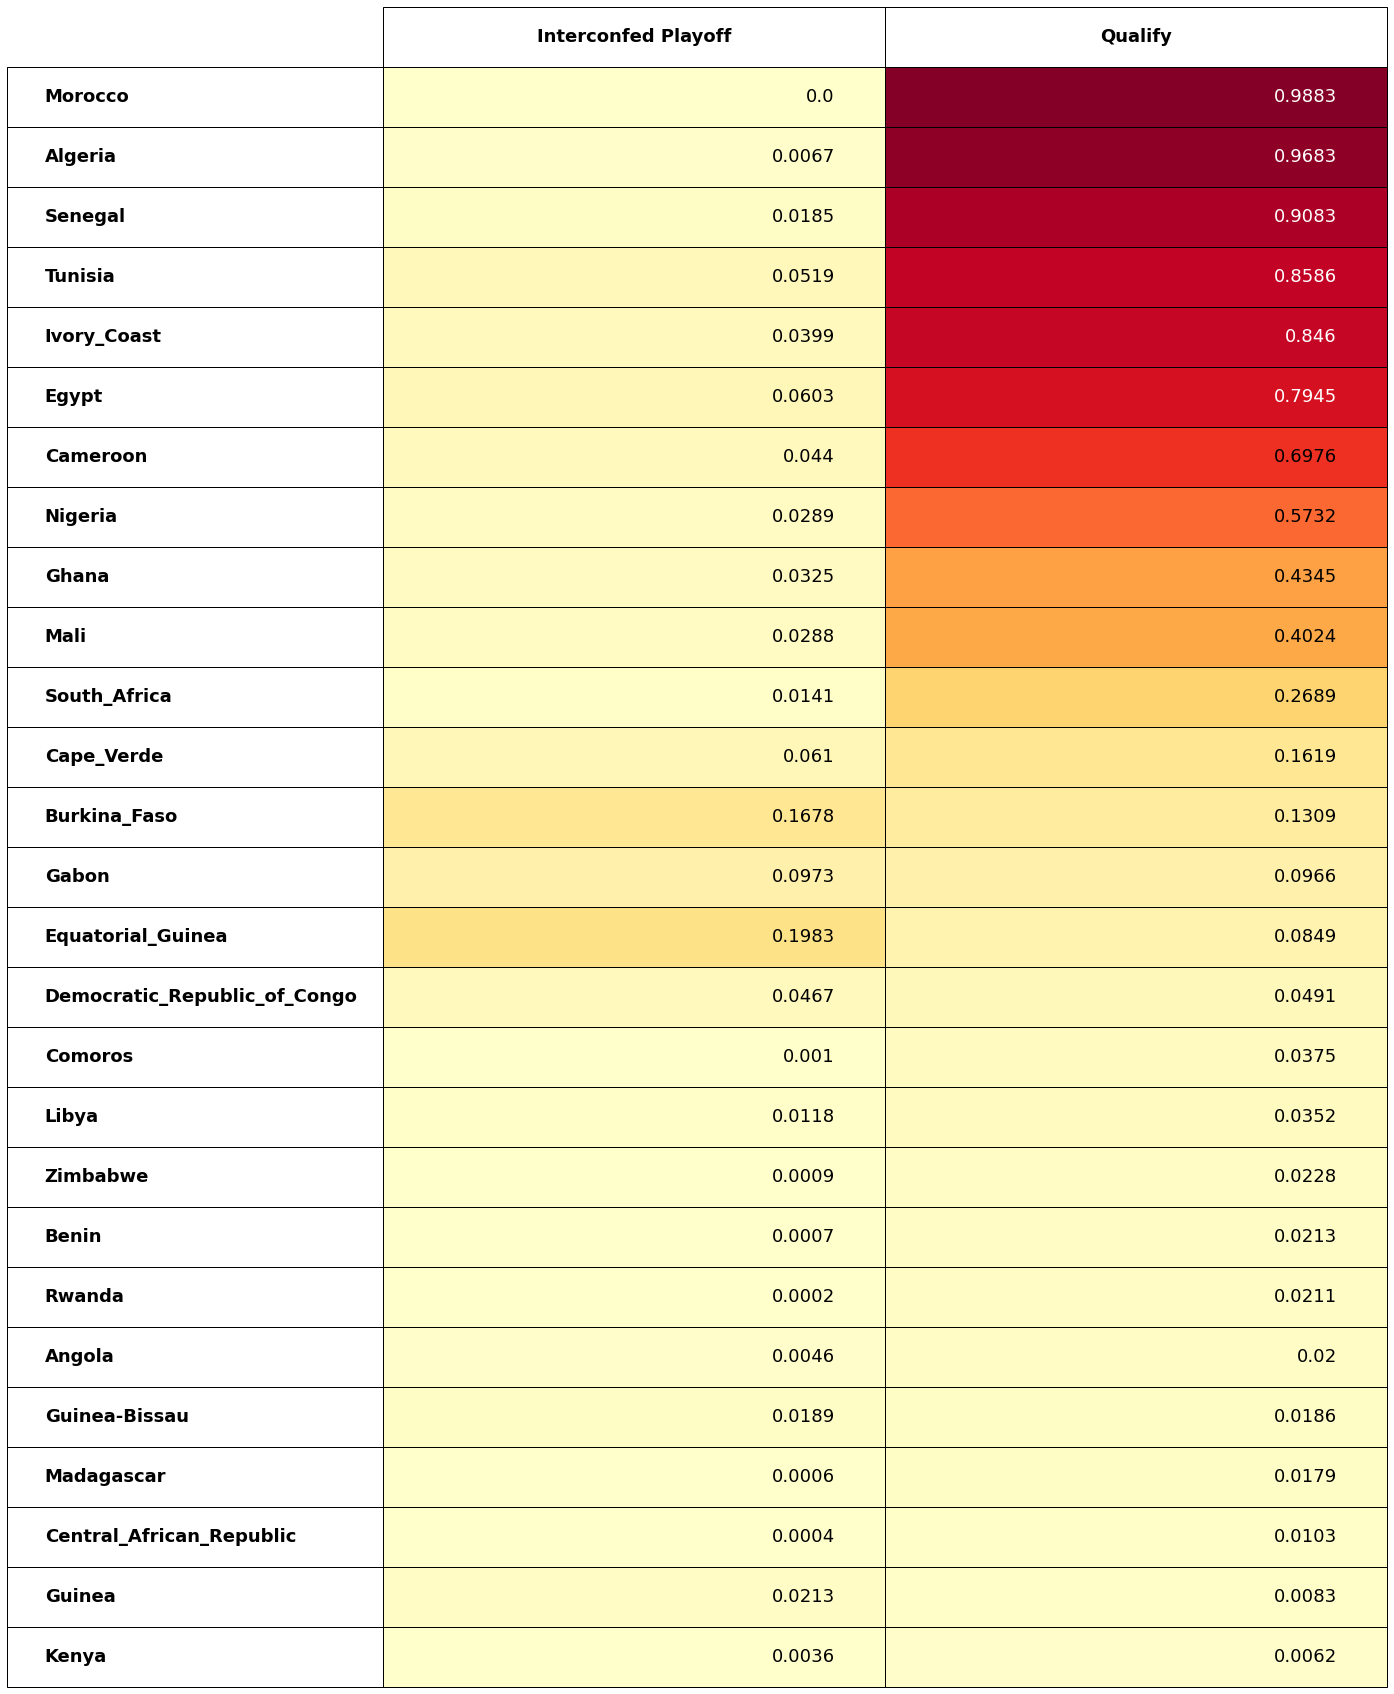

In [371]:
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=sorted_finish.values, cellColours=plt.cm.YlOrRd(sorted_finish.values),
                 rowLabels=sorted_finish.index, colLabels=sorted_finish.columns, 
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(3, 5)

table_props = table.properties()
table_cells = table_props['children']
for cell in table_cells:
    if sum(cell.properties()['facecolor']) < sum(cl.to_rgba('0.4')):
        cell.get_text().set_color('white')

# ab = AnnotationBbox(getImage("./country-flags-main/png1000px/ar.png"), (200, 1837), 
#                     frameon=False, xycoords='figure points')
# ax.add_artist(ab)


for val in range(0,2):
    head = table[0,val]
    head.set_text_props(fontsize=18, fontweight='bold', verticalalignment='center')

for val in range(1,28):
    head = table[val,-1]
    head.set_text_props(fontsize=18, fontweight='bold', verticalalignment='center')

    
plt.show()

Index(['Egypt', 'Burkina_Faso', 'Guinea-Bissau', 'Sierra_Leone', 'Ethiopia',
       'Djibouti'],
      dtype='object')
Index(['Senegal', 'Democratic\nRepublic of Congo', 'Togo', 'Mauritania',
       'Sudan', 'South_Sudan'],
      dtype='object')
Index(['Nigeria', 'South_Africa', 'Zimbabwe', 'Benin', 'Rwanda', 'Lesotho'], dtype='object')
Index(['Cameroon', 'Cape_Verde', 'Libya', 'Angola', 'Eswatini', 'Mauritius'], dtype='object')
Index(['Morocco', 'Zambia', 'Tanzania', 'Niger', 'Congo', 'Eritrea'], dtype='object')
Index(['Ivory_Coast', 'Gabon', 'Kenya', 'Gambia', 'Burundi', 'Seychelles'], dtype='object')
Index(['Algeria', 'Guinea', 'Uganda', 'Mozambique', 'Botswana', 'Somalia'], dtype='object')
Index(['Tunisia', 'Equatorial_Guinea', 'Namibia', 'Malawi', 'Liberia',
       'Sao Tome\nand Principe'],
      dtype='object')


(0.0, 1.0, 0.0, 1.0)

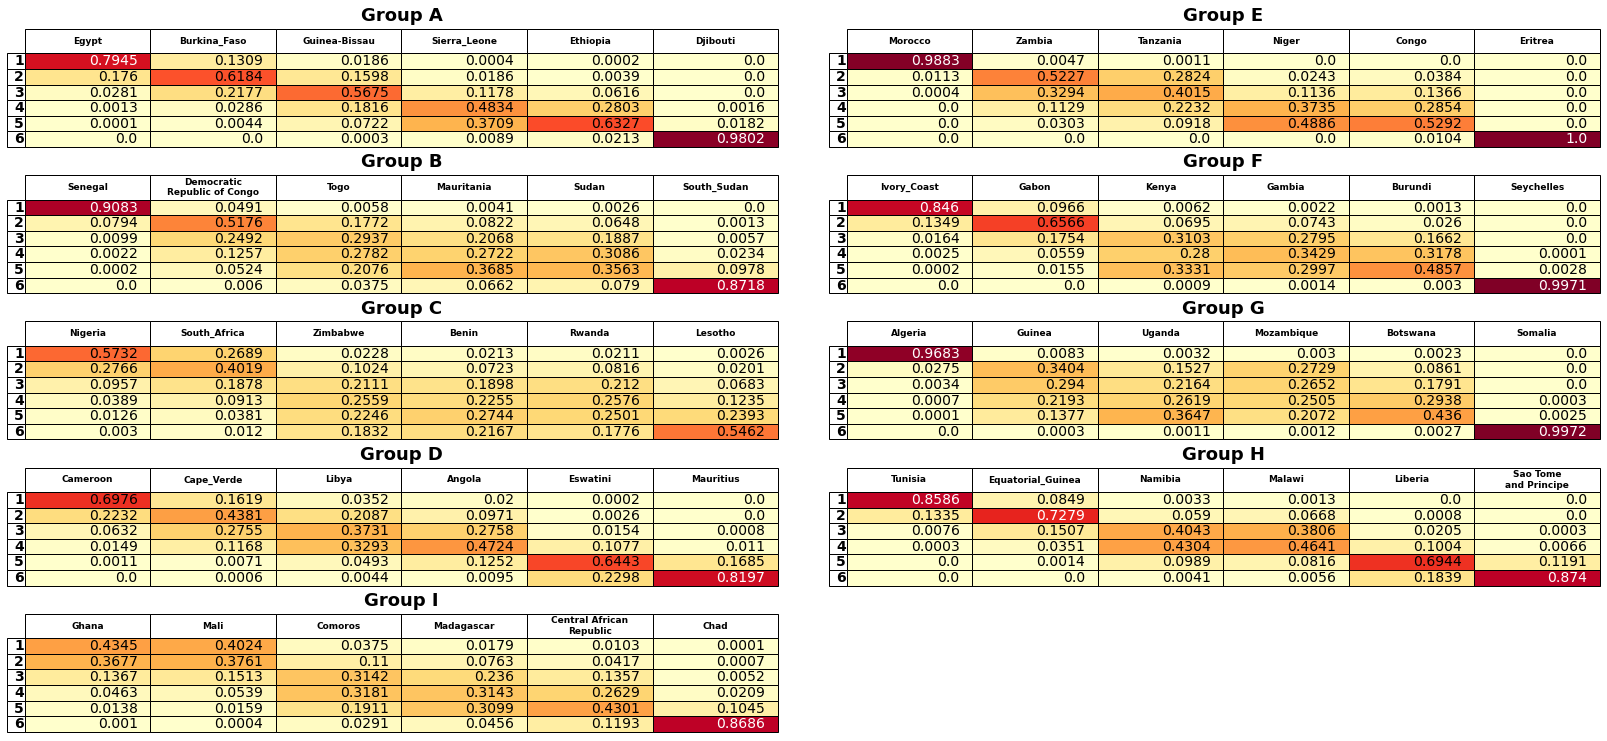

In [372]:
fig, ax = plt.subplots(5, 2, figsize=(27,13), facecolor='white')

for val in range(0,8):
    
    group = groups[val]
    
    pct_fin_group = percent_finish[group].sort_values(1, axis=1, ascending=False)
    
    if group == "B":
        pct_fin_group = pct_fin_group.rename(columns={'Democratic_Republic_of_Congo': 'Democratic\nRepublic of Congo'})

    if group == "H":
        pct_fin_group = pct_fin_group.rename(columns={'Sao_Tome_and_Principe': 'Sao Tome\nand Principe'}) 
        
    print(pct_fin_group.columns)
    
    ax[val % 4][val//4].axis('off')
    ax[val % 4][val//4].axis('tight')
    
    ax[val % 4][val//4].set_title(f"Group {group}", fontsize=18, fontweight='bold')
    
    table = ax[val % 4][val//4].table(cellText=pct_fin_group.values, 
                                     cellColours=plt.cm.YlOrRd(pct_fin_group.values),
                                     rowLabels=pct_fin_group.index, colLabels=pct_fin_group.columns, 
                                     loc='center')
    table.scale(1.1,1.3)
    
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    
    table_props = table.properties()
    table_cells = table_props['children']
    for cell in table_cells:
        if sum(cell.properties()['facecolor']) < sum(cl.to_rgba('0.4')):
            cell.get_text().set_color('white')
    
    for val in range(1,7):
        row = table[val,-1]
        row.set_text_props(fontsize=14, fontweight='bold', verticalalignment='center')
        row.PAD = 0.4

        head = table[0,val-1]
        head.set_text_props(fontsize=9, fontweight='bold', verticalalignment='center')
        head.set_height(0.2)
        
pct_fin_group = percent_finish["I"].sort_values(1, axis=1, ascending=False)
pct_fin_group = pct_fin_group.rename(columns={'Central_African_Republic': 'Central African\nRepublic'})

ax[4][0].axis('off')
ax[4][0].axis('tight')

ax[4][0].set_title(f"Group I", fontsize=18, fontweight='bold')

table = ax[4][0].table(cellText=pct_fin_group.values, 
                                 cellColours=plt.cm.YlOrRd(pct_fin_group.values),
                                 rowLabels=pct_fin_group.index, colLabels=pct_fin_group.columns, 
                                 loc='center')
table.scale(1.1,1.3)

table.auto_set_font_size(False)
table.set_fontsize(14)

table_props = table.properties()
table_cells = table_props['children']
for cell in table_cells:
    if sum(cell.properties()['facecolor']) < sum(cl.to_rgba('0.4')):
        cell.get_text().set_color('white')

for val in range(1,7):
    row = table[val,-1]
    row.set_text_props(fontsize=14, fontweight='bold', verticalalignment='center')
    row.PAD = 0.4

    head = table[0,val-1]
    head.set_text_props(fontsize=9, fontweight='bold', verticalalignment='center')
    head.set_height(0.2)
    
ax[4][1].axis('off')
